In [1]:
%load_ext autoreload
%autoreload 2

import shap
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import copy

from util.util_cnn import CNNModel, data_loaders, first_mnist_batch, test, \
                params_to_filename, params_from_filename, load_mnist_v4_models

from util.naming import *

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain

In [2]:
# load data and pretrained models
data, target = first_mnist_batch(batch_size=200)

background = data[100:200].reshape((-1, 1, 28, 28))
background_target = target[100:200]

data = data[:100]
target = target[:100]

test_images = data[:3].reshape((-1, 1, 28, 28))

model_dict = load_mnist_v4_models()
model_d3 = model_dict[d3_tag]

In [34]:
data.shape

torch.Size([100, 784])

## Shap vs LRP

In [ ]:
e = shap.DeepExplainer(model_d3, background)
shap_values = e.shap_values(test_images)

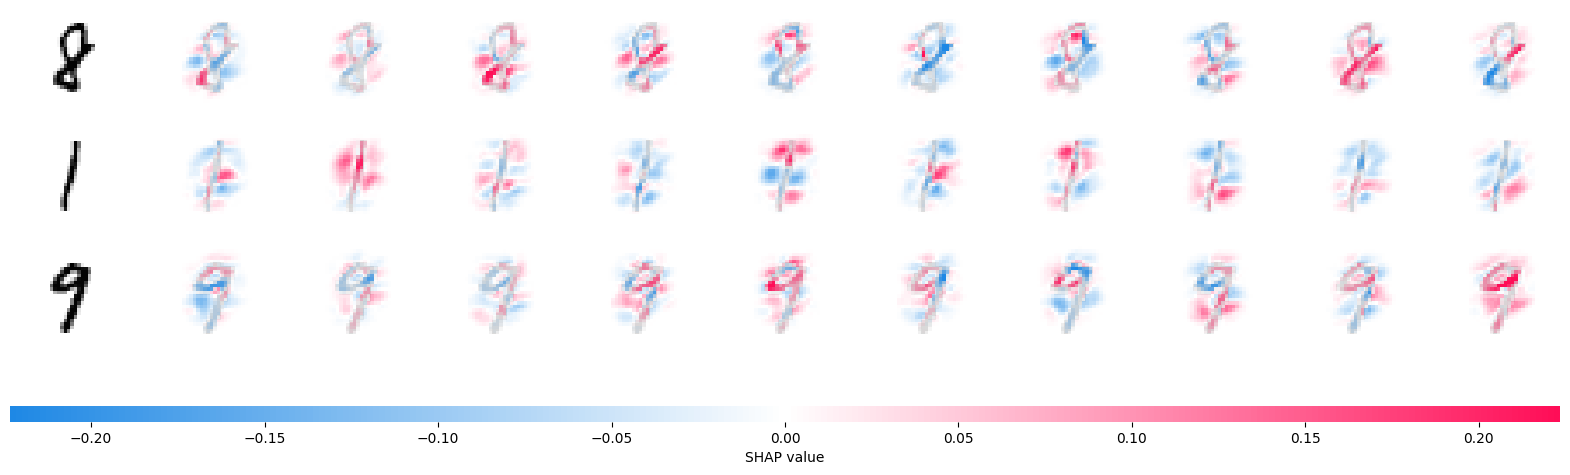

In [37]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)

In [ ]:
relevancies_per_mode = {}

In [78]:
modes = {
    0: "LRP-0.", 
    1: "Gamma. l<4 gamma=0.125",
    2: "Gamma. l<4 gamma=0.25",
    3: "Gamma. l<4 gamma=0.5",
    
    92: "Gamma. l<1000 gamma=0.25",
    99: "Gamma. l<1000 gamma=inf",
   
    # 99: "info."
}

In [39]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    assert type(index) is str
    return copy.deepcopy(relevancies_per_mode[index])

In [40]:
A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

In [79]:
for mode in tqdm(modes.values()):
    if mode in relevancies_per_mode: continue
    rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
    if mode!="info": relevancies_per_mode[mode] = rels

  0%|          | 0/6 [00:00<?, ?it/s]

In [44]:
lrp_numpy = rel(9)[0][:3].numpy()
lrp_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in lrp_numpy[None]]

print(np.array(lrp_numpy).shape)

(1, 3, 28, 28, 1)


In [45]:
lrp_numpy[0].shape

(3, 28, 28, 1)

In [46]:
np.array(shap_numpy).shape, np.array(lrp_numpy).shape, test_numpy.shape

((10, 3, 28, 28, 1), (1, 3, 28, 28, 1), (3, 28, 28, 1))

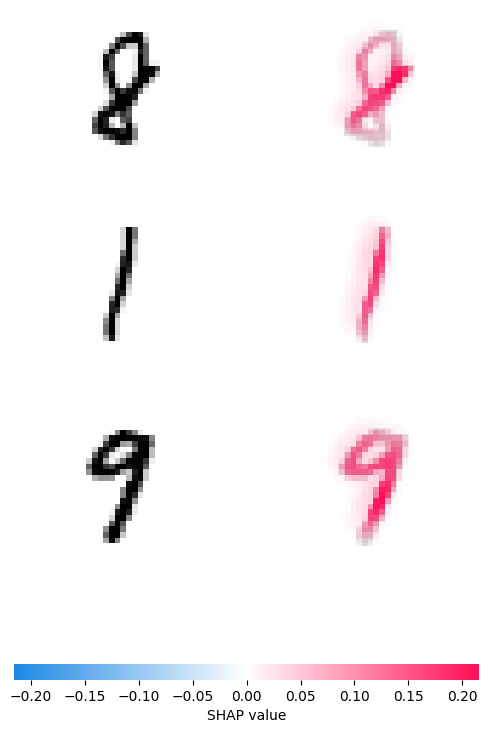

In [47]:
# plot the feature attributions
shap.image_plot(lrp_numpy, -test_numpy)

In [48]:
lrp_numpy[0].shape

(3, 28, 28, 1)

## Import the Explainable model of Pan

In [3]:
from explanations_can_be_manipulated.src.nn.enums import ExplainingMethod, LRPRule
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet
from explanations_can_be_manipulated.src.nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

no display found. Using non-interactive Agg backend


In [4]:
device = 'cpu'
method = ExplainingMethod.lrp

In [5]:
model_d3

CNNModel(
  (seq): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
#import torchvision
#vgg_model = torchvision.models.vgg16(pretrained=True)
vgg_model

In [ ]:
ExplainableNet(vgg_model)

In [30]:
del ExplainableNet #, MaxPool

In [32]:
from explanations_can_be_manipulated.src.nn.networks import ExplainableNet

In [33]:
model = ExplainableNet(model_d3, lrp_rule_next_layers=LRPRule.gamma, gamma=0.25)
model = model.eval().to(device)

True
0.25


TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [17]:
model

ExplainableNet(
  (layers): ModuleList(
    (0): Convolutional(
      (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Convolutional(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Convolutional(
      (conv): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    )
    (3): MaxPool(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    )
    (4): Convolutional(
      (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    )
    (5): Convolutional(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): Convolutional(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (7): MaxPool(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (unpool): MaxUnpool2d(kernel_size=

In [18]:
l=model.layers[1]
l.beta, l.gamma

(0.0, 0.0)

In [81]:
gamma = 0.25
model.change_lrp_rules(alpha=1+gamma, beta=1)

In [84]:
x = data[:1].reshape((-1,1,28,28))
expl, output, classification = get_expl(model, test_images, method)

In [85]:
expl.shape, output.shape, classification.shape

(torch.Size([3, 28, 28]), torch.Size([3, 10]), torch.Size([3]))

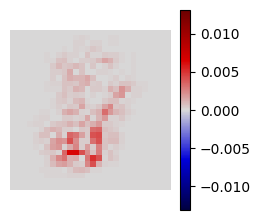

In [87]:
tut_utils.heatmap(expl[0].detach().reshape((28,28)), 2, 2, colorbar=True)

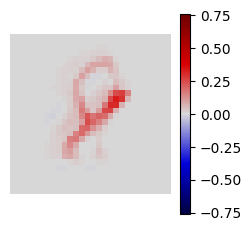

In [89]:
tut_utils.heatmap(rel(92)[0][0].reshape((28,28)), 2, 2, colorbar=True)